In [1]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
def download_and_plot(cryptos, timeframe, start_date, end_date):
    # Controllo degli input
    if len(cryptos) != 2:
        raise ValueError("La lista delle crypto deve contenere esattamente due simboli.")
    
    exchange = ccxt.binance()  # Usa Binance come exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} da {start_date} a {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

    # Associa le due crypto a variabili più leggibili
    crypto1_df = data_frames[cryptos_pairs[0]]
    crypto2_df = data_frames[cryptos_pairs[1]]

    # Calcola il rapporto tra i prezzi di chiusura delle due crypto
    ratio = crypto2_df['close'] / crypto1_df['close']

    # Plot dei dati
    plt.figure(figsize=(14, 8))

    # Grafico della prima crypto
    plt.subplot(3, 1, 1)
    plt.plot(crypto1_df.index, crypto1_df['close'], label=f"{cryptos[0]} Price")
    plt.title(f"{cryptos[0]} Price")
    plt.ylabel('Price (USDT)')
    plt.grid()
    plt.legend()

    # Grafico della seconda crypto
    plt.subplot(3, 1, 2)
    plt.plot(crypto2_df.index, crypto2_df['close'], label=f"{cryptos[1]} Price", color='orange')
    plt.title(f"{cryptos[1]} Price")
    plt.ylabel('Price (USDT)')
    plt.grid()
    plt.legend()

    # Grafico del rapporto
    plt.subplot(3, 1, 3)
    plt.plot(crypto1_df.index, ratio, label=f"{cryptos[1]}/{cryptos[0]} Ratio", color='green')
    plt.title(f"{cryptos[1]} / {cryptos[0]} Price Ratio")
    plt.ylabel('Ratio')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

Scarico i dati per LINK/USDT da 2024-07-01 a 2024-11-20...
Scarico i dati per TAO/USDT da 2024-07-01 a 2024-11-20...


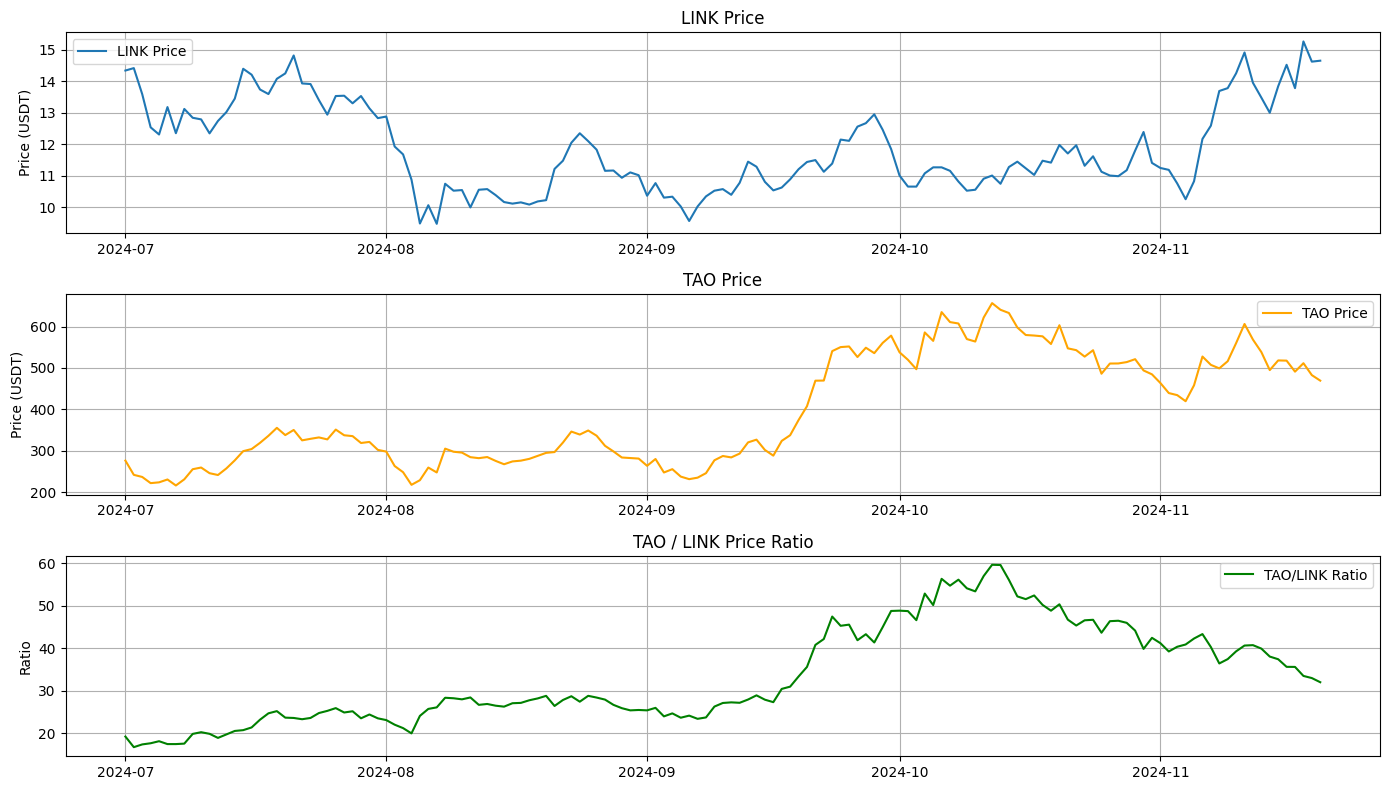

In [5]:
# Esempio di utilizzo
cryptos = ['LINK', 'TAO']  # Specifica le due crypto
timeframe = '1d'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
start_date = '2024-07-01'  # Data di inizio
end_date = '2024-11-20'  # Data di fine

download_and_plot(cryptos, timeframe, start_date, end_date)